In [1]:
import os
from collections import OrderedDict
import logging
from functools import partial

import numpy as np
from astropy.table import Table as ApTable

import scarlet
from scarlet import deblend

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# Make the plots look pretty
matplotlib.rc('font',size=13)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')
# Use the same color cycler as Seaborn
from cycler import cycler
color_cycle = [u'#4c72b0', u'#55a868', u'#c44e52', u'#8172b2', u'#ccb974', u'#64b5cd']
matplotlib.rcParams['axes.prop_cycle'] = cycler("color", color_cycle)

logger = logging.getLogger("deblender")
logger.setLevel(logging.INFO)
logger2 = logging.getLogger("proxmin")
logger2.setLevel(logging.INFO)

In [2]:
# Load the data
_images = np.load("../data/test_sim/images_3.npz")
images = _images["images"]
B = len(images)
# Don't forget to make sure that the images has odd columns and rows
images = scarlet.deblender.reshape_img(images)
filters = _images["filters"]
_psfs = np.load("../data/test_sim/psfs.npz")
psfs = _psfs["psfs"]
if np.all(_psfs["filters"]!=filters):
    raise Exception("PSF and image filters do not match")
catalog = ApTable.read("../data/test_sim/true_catalog_3.fits")

In [3]:
_peaks = np.array([np.array(catalog["x"]), np.array(catalog["y"])]).T
# For now, only use a single component for each object
src_list = np.unique(catalog["index"])
peaks = np.zeros((len(src_list), 2))
for sid in src_list:
    src = catalog[catalog["index"]==sid][0]
    peaks[sid] = [src["x"], src["y"]]

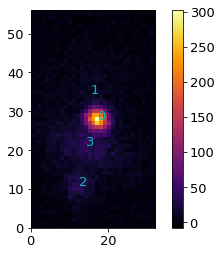

In [4]:
plt.imshow(images[0])
plt.colorbar()
for n, (px,py) in enumerate(peaks):
    plt.text(px, py, str(n), color='c')
plt.xlim([0,images[0].shape[1]-1])
plt.ylim([0, images[0].shape[0]-1])
plt.show()

In [5]:
result = deblend(
    images,
    peaks=peaks,
    constraints=["MS"]*len(peaks),
    psf=None,
    max_iter=500,
    e_rel=1e-2,
    l0_thresh=1,
    fit_positions=True,
    traceback=False,
)

INFO:proxmin.algorithms:Completed 501 iterations


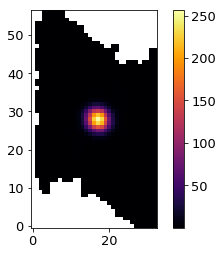

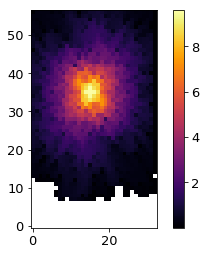

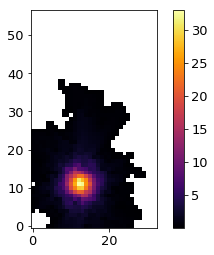

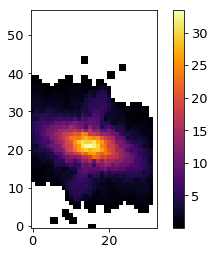

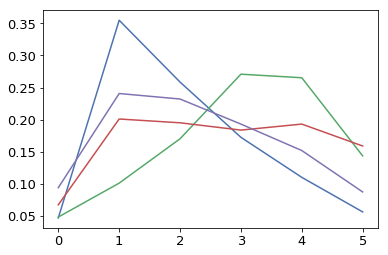

In [6]:
band = 0
for k in range(result.K):
    models = result.get_model(k)
    model = models[band]
    plt.imshow(np.ma.array(model, mask=model==0))
    plt.colorbar()
    plt.show()
for k in range(result.K):
    plt.plot(result.A[:,k])
plt.show()

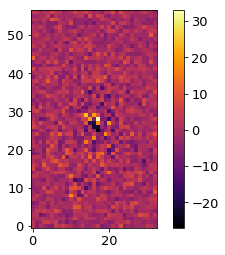

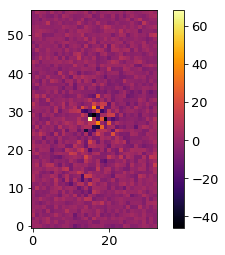

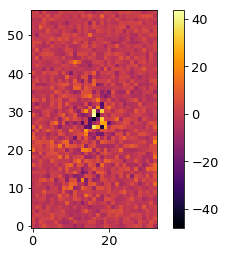

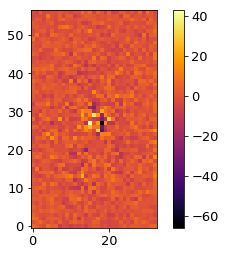

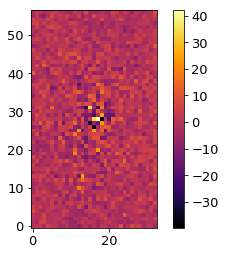

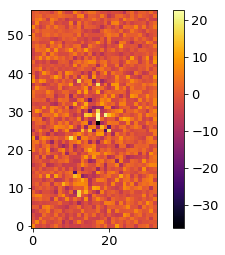

In [8]:
model = result.get_model(combine=True)
for b in range(B):
    plt.imshow(images[b]-model[b])
    plt.colorbar()
    plt.show()

In [12]:
from functools import partial
from proxmin import operators as po
from scarlet.operators import prox_strict_monotonic

it = 0
def prox_compact(S, step, thresh=0, img_shape=None):
    global it
    it_max = 30
    #it_min = 10
    K = S.shape[0]

    if it < it_max:
        S = po.prox_plus(S, step)
        it += 1
        K = S.shape[0]
        ny,nx = img_shape
        x,y = np.meshgrid(np.arange(nx),np.arange(ny))
        # radius wrt center of central pixel
        r = np.sqrt((x-0.5*nx + 0.5)**2 + (y-0.5*ny + 0.5)**2).flatten()
        radius = max(it,5) 
        mask = r > radius
        for k in range(K):
            S[k][mask] = 0
    else:
        from scipy.ndimage import label
        S = po.prox_soft_plus(S, step, thresh=thresh)
        for k in range(K):
            labels, n_labels = label(S[k].reshape(img_shape))
            if n_labels > 1:
                # find out which label has the peak
                peak_label = labels[img_shape[0]/2, img_shape[1]/2]
                if peak_label != 0:
                    #raise AssertionError("peak %d not found by label" % k)
                    mask = ((labels > 0) & (labels != peak_label)).flatten()
                    S[k][mask] = 0
    return S

l0_thresh=1
l1_thresh = None
B, N, M = images.shape

if l0_thresh is None and l1_thresh is None:
    prox_S = po.prox_plus
else:
    # L0 has preference
    if l0_thresh is not None:
        if l1_thresh is not None:
            logger.warn("weights warning: l1_thresh ignored in favor of l0_thresh")
        prox_S = partial(po.prox_hard, thresh=l0_thresh)
    else:
        prox_S = partial(po.prox_soft_plus, thresh=l1_thresh)
seeks = [True]*len(peaks)
prox_S = prox_strict_monotonic(shape=(N,M), seeks=seeks, prox_chain=prox_S)
#prox_S = partial(prox_compact, thresh=l0_thresh, img_shape=(57,33))

result = deblend(images, 
                 peaks=peaks, 
                 psf=None,
                 constraints="S",
                 monotonicUseNearest=False,
                 prox_S=prox_S,
                 max_iter=500, e_rel=1e-3, e_abs=[1e-2, l0_thresh], 
                 traceback=False,
                 update_order=[1,0],
                 fit_positions=True
)

INFO:proxmin.algorithms:Completed 40 iterations


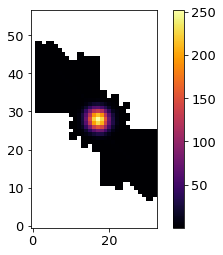

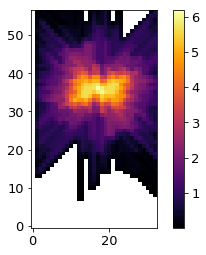

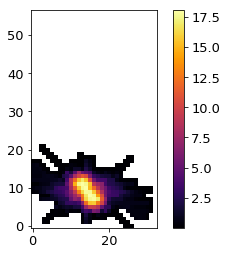

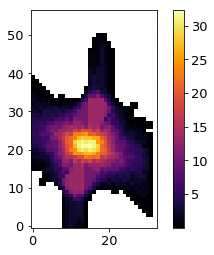

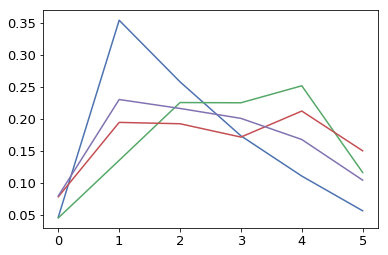

In [13]:
band = 0
for k in range(result.K):
    models = result.get_model(k)
    model = models[band]
    plt.imshow(np.ma.array(model, mask=model==0))
    plt.colorbar()
    plt.show()
for k in range(result.K):
    plt.plot(result.A[:,k])
plt.show()

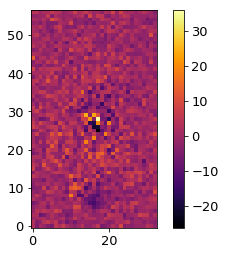

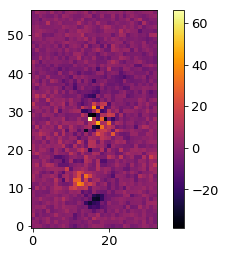

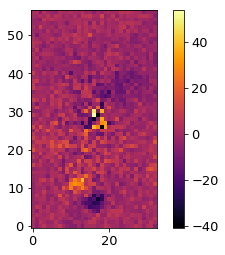

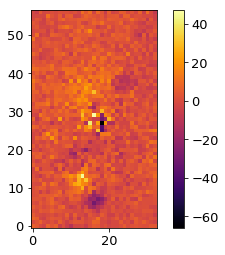

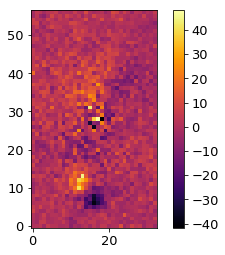

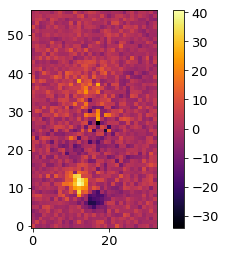

In [14]:
model = result.get_model(combine=True)
for b in range(B):
    plt.imshow(images[b]-model[b])
    plt.colorbar()
    plt.show()